# **Imports**

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 880 kB 49.8 MB/s 
     |████████████████████████████████| 6.6 MB 20.1 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=608ed7038e035235f17b0430f79c279fa9e95bf253ed59e318fd3108a7cec1fe
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json
import os
import re
import pandas as pd 
import numpy as np
import random
import time
import datetime
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn import functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import random_split
torch.manual_seed(42)

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AdamW,  get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

import warnings
warnings.simplefilter('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Utils**

In [ ]:
# reproducibility
def seed_everything(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# **Load dataset**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8')

In [ ]:
data.head()

,id,joke,rank
0,5tz52q,I hate how you cannot even say black paint any...,1
1,5tz4dd,What is the difference between a Jew in Nazi G...,0
2,5tz319,I recently went to America..... ...and being t...,0
3,5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
4,5tz1pc,You hear about the University book store worke...,0


In [ ]:
data['Text_length'] = data.joke.str.split().str.len()

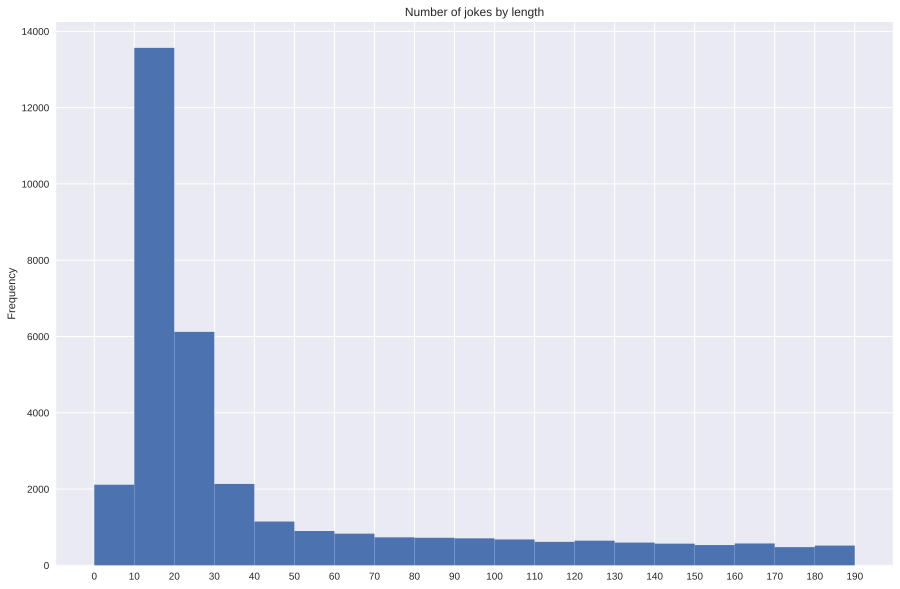

In [ ]:
data[(data['rank'] == 4)]['Text_length'].plot(kind='hist', bins=range(0, 200, 10), xticks=range(0, 200,10), figsize=(15, 10), title='Number of jokes by length')
plt.show()

In [ ]:
data[(data['rank'] == 4)]['Text_length'].mean()

70.74664508380764

In [ ]:
df = data[(data['rank'] == 4) & (data['Text_length'] >= 8) & (data['Text_length'] <=70)]

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

id             0
joke           0
rank           0
Text_length    0
dtype: int64

# **Load GPT2 Tokenizer from huggingface's transformers**

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

### Limit the maximum token length because of RAM limitations.

In [ ]:
joke_tokens = pd.DataFrame(df[['joke']].copy())
joke_tokens["len_tokens"] = joke_tokens.applymap(lambda x: len(tokenizer.encode(x)))
joke_tokens = joke_tokens.sort_values("len_tokens", ascending=False)
joke_tokens

,joke,len_tokens
82005,An elderly woman walks into a sex shop. She sl...,174
184005,DICTIONARY FOR DECODING WOMEN'S PERSONAL ADS. ...,159
131672,"shades of grey. #, #, #, #bbb, #ccc, #eee, #,...",150
121900,Are you ready kids? AYE AYE CAPTAIN! I cannot ...,134
47866,"Reading it one time might be not enough.. -""He...",132
...,...,...
175546,Nothing beats a beautiful woman.. Except Chris...,9
148176,I know someone who talks like an owl.,9
175339,Russian nesting dolls are so full of themselves..,9
153599,I cannot stand being in a wheelchair.. ...,9


In [ ]:
jokes = joke_tokens.joke[joke_tokens['len_tokens'] <= int(joke_tokens['len_tokens'].max())]
jokes.shape

(26250,)

In [ ]:
max_flavour = max([len(tokenizer.encode(joke)) for joke in jokes])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 174 tokens long.


### **Data Loaders**

In [ ]:
bs = 16 # batchsize # 32 was

In [ ]:
class JokeDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):
        self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the 
            pad token. 
            """

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                     truncation=True, 
                                     max_length=max_length, 
                                     padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not. 
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = JokeDataset(jokes, tokenizer, max_length=max_flavour)

### **Split into training and validation sets**

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 23625 samples for training, and 2625 samples for validation testing'

In [ ]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = bs 
        )

# **Load pretrained GPT2 from huggingface**

In [ ]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [ ]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)


model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

### **Fine-tune GPT2**

In [ ]:
# This step is optional but will enable reproducible runs.
seed_val = 42
seed_everything(seed_val)

In [ ]:
epochs = 10
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, 
# and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,  # 5e-4, -- was!
                  eps = 1e-8
                )

In [ ]:
"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

### **Train**

In [28]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.8634875416755676. Time:0:02:28
Example output:  bipartisan.,", said the United States of America.The federal government is on an about," said the word that is on its bottom.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.6806207895278931. Time:0:04:56
Example output:  increasingIt is not an inch high. What is an inch low?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.8017030358314514. Time:0:07:23
Example output: dayOne day, I woke up in a hotel room with a phone. I asked if I could call him. He said not yet. I told him that I had left the phone behind and left your password on the fridge. I turned it off. Then I took out my phone and answered the phone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.8338105082511902. Time:0:09:52
Example output:  HangSonic?. I think.. I think.. that would be... fun. But.. I just.. I just.. I just.. I just.... I just did not think it would be so bad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.7343008518218994. Time:0:12:20
Example output:  foodsA baby girl walks around the house.. A girl walks around the kitchen table. She looks very puzzled.... The girl asks her sister, "You really think my dad should eat broccoli?" The girl responds, "No!" she says, "I like that, and I like broccoli!" She has a big smile and is quite proud.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.6097426414489746. Time:0:14:48
Example output:  trailI bought a red couch


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.7246824502944946. Time:0:17:16
Example output: intendYou do not know the difference between a cat and a frog.... But a rabbit can swallow its own tail.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.6006686091423035. Time:0:19:43
Example output:  surroundWhat does the difference between a baby's brain and a child's body?. A baby grows up to be a scientist.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.643207848072052. Time:0:22:11
Example output:  reflexS: Yeah. I can smell your dog.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.60799241065979. Time:0:24:38
Example output:  displayA new life force comes into the universe.. A new life force comes into the universe


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.5708926320075989. Time:0:27:06
Example output:  pastorIn a very personal way, I feel like a guy walking down the street with his girlfriend..


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.557652473449707. Time:0:29:33
Example output:  illicitThey were walking by a bar..... After seeing a dead man standing there holding a knife.... Suddenly someone in his late twenties approaches them and grabs the knife and stabs them.  witnesses describe him as a handsome young man from Chicago.... The young man grabs the knife to kill himself, then a police officer orders him to stand still. he looks up to the officer and says "I do not care how long you stand there, they do not care if I will run or not." "Great," the police officer replies. "Well, whatever happened to those who fell out of the river?" "No, I will do them proud."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.6780978441238403. Time:0:32:03
Example output:  LiberationWhat do you call a penis that flies into a vagina?. An Italian joke


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.5189592242240906. Time:0:34:30
Example output:  NamThe first time I met a porn star was in the bathtub. But, that was in the past....
Average Training Loss: 0.9223271687852425. Epoch time: 0:36:23
Validation loss: 0.5526911074464972. Validation Time: 0:01:20
Beginning epoch 2 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.5666998028755188. Time:0:02:27
Example output: IONMy brother does not know what he is talking about. It seems to be a joke.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.6554403901100159. Time:0:04:54
Example output:  glimpseAt the corner of the road the sign is going, The corner of the road goes to the corner. We cross the road, It turns into the corner,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.4390923082828522. Time:0:07:21
Example output:  LaureWhat do you call a blind man whose eyesight is?. Blind man.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.5560466051101685. Time:0:09:48
Example output: ismWe are proud to offer our clients with a biggest gift: a lifetime supply of. Jokes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.5433482527732849. Time:0:12:15
Example output: ounTwo nuns walk into a bar.... one asks if they could borrow money and the other says "no, thanks." The bartender says "That means that you will be the only one with the money"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.4869562089443207. Time:0:14:42
Example output:  electionWhat do you call a prostitute with no teeth?. A dead body.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.5044853091239929. Time:0:17:08
Example output:  crazyA Jew walks into a bar.. A Jew looks up and says: "Hey guys, I know what you are getting here. I just put your hands on my shoulder, and I cannot see you!" Jew says: "I know!" The Jew says: "What do you mean, I will never meet you?" A Jew says: "Well, I have never met you before."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.5688721537590027. Time:0:19:36
Example output:  benchWhat do you call a blind man's foot?. A foot of chalk.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.5975474119186401. Time:0:22:02
Example output:  incorporatedWhat do you call a baby with no nipples?. A baby with nipples


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5260071754455566. Time:0:24:29
Example output: PeterHow many girls does it take to change a lightbulb?. None. They will just sit in their room.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.5928611755371094. Time:0:26:55
Example output: uringThe reason that the Russian economy relies so much on coal is because of a lot of jobs lost to mining in the past.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.49559885263442993. Time:0:29:22
Example output:  reproductiveI was a huge fan of John Wayne's films... Now I think he is dead


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.669619619846344. Time:0:31:49
Example output:  zoneA man walks into a bar with his wife. The bartender says "you will have no choice but to be a slut by the end of your day." The man goes on to say "Do you know what it is called? Fuck me!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.4373281002044678. Time:0:34:17
Example output:  commitsWhat is the difference between a  year old and a  year old's  year old?. If they go to school, I can help them.
Average Training Loss: 0.5434649768679547. Epoch time: 0:36:09
Validation loss: 0.5219251558636174. Validation Time: 0:01:20
Beginning epoch 3 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.597189724445343. Time:0:02:27
Example output:  ironyMy dad told me that I could eat pizza from  pies. The only reason I had to cut the pizza short was because I did not want to eat that damn pizza again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.5701197981834412. Time:0:04:54
Example output:  SahI just dumped my wife at the end of the night.... So I had  beers and went out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.5620827078819275. Time:0:07:21
Example output:  BryanWhy was the sun and moon not included in the Moon?. Because you cannot see them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.4502963423728943. Time:0:09:47
Example output:  spiritsI just tried to kill all the kids in my house for Halloween.... They all started crying hysterically..


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.407854288816452. Time:0:12:14
Example output:  seesWhat is the hardest part about driving a Porsche, a Rolex or Rolex?. Not being able to drive it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.43049466609954834. Time:0:14:41
Example output:  hungryWhat is the difference between a duck and a bear?. The duck won the trophy in the raffle.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.46532633900642395. Time:0:17:07
Example output:  PTA man is walking through the woods when he sees a sign that reads, "I am looking for a place to hang my stick.." He leaves the woods and goes straight to a pick up truck. He starts to pull up the fence, and as he approaches the pick up truck, a group of them begin taking aim at him. He says to the driver, "Man, you are so hot, you can not do this anywhere else."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.4689355194568634. Time:0:19:34
Example output: üDid you know the German Army was the fastest in history?. Its average soldiers died on its feet.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.592021644115448. Time:0:22:00
Example output: ruceWhat do you call a black girl with no legs?. A dyslexic.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5602765083312988. Time:0:24:27
Example output:  derivativesWhat is the difference between a Mexican and a Mexican?. A Mexican does not want to be a Mexican.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.6280316710472107. Time:0:26:53
Example output: A man was talking to his wife in a pub. She said to him "I have come a long way in years".


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.5901554226875305. Time:0:29:20
Example output:  rememberingWhy do black people never go to church?. Because they are afraid of shitposters.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.48027119040489197. Time:0:31:46
Example output:  SourcesWhat do they call a prostitute who steals  condoms?. The prostitute from a third world country.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.4906025826931. Time:0:34:12
Example output: emsWhat do you call an Irishman who makes up everything?. A Dubliner
Average Training Loss: 0.5070456674797921. Epoch time: 0:36:04
Validation loss: 0.5027637160185612. Validation Time: 0:01:19
Beginning epoch 4 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.37149256467819214. Time:0:02:26
Example output: tzWhat is the difference between Jesus and a Jewish baker?. One is a lot cheaper than the other, but one is a lot higher than the other.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.32734957337379456. Time:0:04:53
Example output: maticI tried to find a Jewish joke in the book. Unfortunately, the title was Jewish.. Then I remembered that "The Jews invented bread"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.6606787443161011. Time:0:07:19
Example output:  syndWhat Is the difference between a black man in prison and a pregnant white woman?. One is a stable state, while the other is a nightmare.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.4040151536464691. Time:0:09:46
Example output:  gamWhat did the chicken say to the pot of boiling water?. You can eat whatever you want, as long as it is made in -shell.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.4616416096687317. Time:0:12:12
Example output:  injuryI like my coffee like I like my women,. I like my coffee like I like my women. Women like my coffee like I like my coffee, men like my coffee like I like my women.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.3934858441352844. Time:0:14:39
Example output: azaI want to make the people in Mexico like they are back home.. It is like back home in 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.42592141032218933. Time:0:17:05
Example output:  membraneHow much space do blackjack players have?. About  cents.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.4864404797554016. Time:0:19:31
Example output: ijingWhat does a pedophile eat?. Orange juice


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.42888501286506653. Time:0:21:57
Example output:  castWhat is the difference between a lentil and a lentil and how many kids does it take to grow an ass?. One's a pig, the other's a chickpea.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5002031922340393. Time:0:24:24
Example output:  purchA programmer goes to sleep. He is thinking "Why am I dreaming?". The programmer goes to sleep and says "Good wake up. I am tired now."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.4209398925304413. Time:0:26:50
Example output:  shouldersWhat is worse than getting a compliment in return?. Getting a compliment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.39904043078422546. Time:0:29:16
Example output:  builtA joke that has been in print since the time the Titanic hit the iceberg.... and now appears in an issue of the magazine


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.4145691692829132. Time:0:31:43
Example output:  openlyWhy are black people so good friends?. Because they can see through every fucking wall.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.42611756920814514. Time:0:34:09
Example output:  haltedI am not even remotely racist.... but how do you know?. You are never going to put pepper on my chin.
Average Training Loss: 0.47588122542758365. Epoch time: 0:36:00
Validation loss: 0.4892123421033224. Validation Time: 0:01:19
Beginning epoch 5 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.5008214116096497. Time:0:02:26
Example output:  NikWhat is the difference between the time traveling /r/jokes community and the /r/funny subreddit?. The r/funny sub does not shut up about jokes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.5518077611923218. Time:0:04:52
Example output:  tinA man walks into a bar..... and he walks in. So he orders a drink and sees the man next to him, sitting down on the table opposite him. The man looks at him suspiciously and says, "Hey, do you think I am going to eat this?". The man replies, "Well then, you should not have to eat that far."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.44116899371147156. Time:0:07:19
Example output:  clinicalWhat do you call a gay dinosaur that cannot eat?. A pterodactyl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.5614089965820312. Time:0:09:45
Example output: lectionsA guy with his arms in the air.... A guy with his arms in the air and his legs in the ground is staring at the ceiling, his ears ringing, and he is terrified. So he picks up his arm, looks at the ceiling, and says "No, no!" The guy says "I did not say you did not have arms in the air."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.4236963391304016. Time:0:12:12
Example output: elsWhat do you call an angry, racist cow?. A Beef Stroganoff.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.5677560567855835. Time:0:14:39
Example output: labI have just signed up to work for the world's worst bank.... I do not think I can do it alone


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.5579681992530823. Time:0:17:05
Example output:  tripleDid you hear about the guy who invented the "gatorade maker" that cost $?. It is now a national drink with tons of calories.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.5052133202552795. Time:0:19:31
Example output: 220What do you call a nun in a wheelchair?. Virgin Mobile.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.4339526295661926. Time:0:21:58
Example output:  SeeWhat do you call a black guy who is a dictator?. Vladimir Putin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.3704257905483246. Time:0:24:24
Example output: @@I was thinking about getting pregnant this morning.. I had to explain myself to myself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.47363394498825073. Time:0:26:50
Example output:  hostThere were  policemen here today.....one, an old, balding man, and an old, dead-head, a goth, and a clown. One of them turns to the other and says, "You will all have trouble finding the clown today."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.5165272355079651. Time:0:29:16
Example output: roleI had a scare earlier.. My roommate told me I was going to get a "G" on the side. I told him it is because I am a lesbian, that is the only way to get it. He then said, "why?" I replied, "because in your case you are still here."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.3495626151561737. Time:0:31:43
Example output: iacMy wife is like Cinderella.. Not very good, but she always comes back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3910631537437439. Time:0:34:09
Example output:  LDOne year ago, I went to college for my masters in History. I have not met a single black person in it and I never knew they were there at all. Now I have to go back and ask the teacher if I could take that exam. I do not know what to tell them.
Average Training Loss: 0.4491690215058801. Epoch time: 0:36:01
Validation loss: 0.47960845042358746. Validation Time: 0:01:19
Beginning epoch 6 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.4280889928340912. Time:0:02:26
Example output:  ListenI thought the guy in the black van was robbing me.. But then i realized he was robbing a pretty good fraction of the black people who have the audacity to say what they want to hear.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.4027038812637329. Time:0:04:53
Example output:  dyI was just walking up to my friend at the bar.. I just remember saying, "Hey buddy, I feel like I was just fingering this kid, are you sure?" "I am sure" he replied, looking down and smiling thinly. "Was not that you?" "No, just that I was fingering this kid." "Are you sure?" "Nope." I replied, dropping the kids off.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.37497478723526. Time:0:07:20
Example output:  DomesticI got an F in Chemistry.... It really made my day.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.34759339690208435. Time:0:09:47
Example output:  beneficiariesHow does a Mexican get to school?. Tequila


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.33324503898620605. Time:0:12:13
Example output:  TitleMy lesbian neighbours were having a threesome last night. They decided to ask for a place to get their drinks. But I wanted to stay out in the dark.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.3979465365409851. Time:0:14:39
Example output:  μHow do you get two nuns together?. Do a double take


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.49619153141975403. Time:0:17:05
Example output:  sellingIt turns out that we all like being spoiled. You can read the whole thing here


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.553540825843811. Time:0:19:31
Example output:  migrantI once shoed a used condoms.... I only need a couple dozen in there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.47075846791267395. Time:0:21:57
Example output: ivelyI am just going to give my friend a blowjob. She only responds when I cum inside her..... But once I hit the cum she just giggles and says "You got me."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.39348912239074707. Time:0:24:23
Example output:  orderWhat is the difference between a snowman and a snowwoman?. Snowballs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.3734757602214813. Time:0:26:50
Example output:  VPNHow many Vietnam vets does it take to screw in a lightbulb?. A good question.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.5130688548088074. Time:0:29:16
Example output:  explanationI like my women like I like my coffee.. Without a penis


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.3063994348049164. Time:0:31:42
Example output:  BachDid you hear about the farmer who had his land chopped down?. At his funeral, he planted a great deal of hay and corn.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.40130844712257385. Time:0:34:09
Example output:  folderWhat is the difference between light and hard?. I can sleep with a light on.
Average Training Loss: 0.42616724914485893. Epoch time: 0:36:00
Validation loss: 0.47449870615294487. Validation Time: 0:01:19
Beginning epoch 7 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.37336990237236023. Time:0:02:27
Example output:  buildingWhat do you call a midget with no arms?. An ambulance!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.42596015334129333. Time:0:04:53
Example output:  BabylonWhat is a pirate's favourite letter?. Sir, I do not know, but it is on your mind.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.3295353651046753. Time:0:07:19
Example output: perialWhy do cows have hooves?. Because they lactose.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.5723133683204651. Time:0:09:45
Example output:  rentsHow many ears does it take to fit an octopus?. Ten. Ten o'Clock. Ten o'Clock Oscillator!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.384663850069046. Time:0:12:11
Example output:  RegWhat did the fish say when it got to the other side?. That was great, I will have to ask my guide.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.4290318489074707. Time:0:14:37
Example output: olasWhy did the midget fall into the well?. He heard the muffler was blowing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.4807069003582001. Time:0:17:04
Example output:  responsesWhy did the blind man get stabbed in the jaw?. He was trying to pull out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.3309726417064667. Time:0:19:30
Example output:  attendanceTwo antennas walk into a bar. and two antennas walk into a bar. and one says to the other, "hey what do you think we will be doing tonight?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.43704086542129517. Time:0:21:56
Example output:  rigidA man calls his doctor and asks, 'Doc, can I get some Viagra?'. Doc replies, 'no,' and goes to buy condoms himself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5062760710716248. Time:0:24:23
Example output: groI asked my son about his sexuality. He told me he said "if he were in a band or if he were into airplanes... Would you say he would want to become a pilot"?. I said... That is his right, you have a right, too!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.37830060720443726. Time:0:26:49
Example output:  GreMy wife and I were having lunch.... She asked me to join her in a good conversation. So, I pushed my friend down the stairs, then walked up to her.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.43698808550834656. Time:0:29:16
Example output: uraWhat is the difference between a BMW and a Harley?. A BMW does not have a suspension. A Harley does.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.4639502167701721. Time:0:31:42
Example output:  2020My friend Dave just found out I had a reptile dysfunction.. He said it only takes one reptile to screw in a lightbulb.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.46241238713264465. Time:0:34:08
Example output:  chargingMy girlfriend asked me to make a new bra.. I came over late and asked "where does it fit?". "Between the breasts" I replied "between my legs"
Average Training Loss: 0.4068661250209356. Epoch time: 0:36:00
Validation loss: 0.4727638815388535. Validation Time: 0:01:19
Beginning epoch 8 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.387649804353714. Time:0:02:26
Example output:  SarMy dog got a new name today. So we named him Jack


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.372447669506073. Time:0:04:52
Example output:  JasWhy did the leper get on a sinking ship?. Because she was sinking fast.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.29230278730392456. Time:0:07:19
Example output:  permitMy dad said he only smokes weed......in the summertime.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.5056694746017456. Time:0:09:44
Example output:  AdministratorWhat did the cannibal do after he dumped his girlfriend?. Wiped his ass.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.37511855363845825. Time:0:12:11
Example output:  EVENTSHow to get into a bad mood?. Beat the shit out of the room for a second.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.3541317582130432. Time:0:14:37
Example output:  MentalA new study shows that % of all people in North Korea are mentally deranged.... Some have even crossed the border into Japan.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.3286179006099701. Time:0:17:03
Example output: idsMy dad said "dad, can I get a blowjob on here?". So I shot him.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.4573045074939728. Time:0:19:29
Example output: ceansWhat is it like to play Call of Duty?. You always get  upvotes, then you are dead.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.41612255573272705. Time:0:21:55
Example output:  geneticallyWhy was the hipster hitler's house so haunted?. Because he was at home playing hide and seek with his wife.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.3527803421020508. Time:0:24:22
Example output:  adviceMy friend got fired from the bakery because of his obsession with the letter C,. he told me, "I am not happy about that, that is a big deal for someone who loves the letter C!" It is a shame I was fired, as it is the last thing his family would ever need in a cake truck


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.3643493354320526. Time:0:26:49
Example output:  incompleteWhat is the most awkward part of a threesome?. It is the middle finger


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.3659772276878357. Time:0:29:15
Example output: commentWhat do you call a black man in a wheelchair?. Stevie Wonder answering the iron.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.36822083592414856. Time:0:31:41
Example output:  pilotWhy did the police officer get fired?. To be fired.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3808288276195526. Time:0:34:07
Example output: gersWhat do the left and right breasts have in common?. They do not come in a different shape until you try to eat one.
Average Training Loss: 0.39233540371817033. Epoch time: 0:35:59
Validation loss: 0.4709493314678019. Validation Time: 0:01:19
Beginning epoch 9 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.31293126940727234. Time:0:02:26
Example output:  mutationHow does a Jew play the board game Un'Goro?. With 'in the sand'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.3415873646736145. Time:0:04:52
Example output:  DriverA kid is getting ready to go out and he is asked what day it is that he needs to get dressed.... He explains, "It is the first day of school today and I want to get dressed as a clown so I get dressed in my clothes." He goes home with two bags of candy, a box of crackers, a can of orange juice, and a can of soda. He gets dressed and says, "I forgot to feed the dog yesterday! Can I have some milk instead?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.5037127137184143. Time:0:07:20
Example output: itiWho was the worst person to hit on the head?. Stephen Hawking.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.2817125618457794. Time:0:09:45
Example output: fffMy boss asked me to change my phone number.. I said, "Of course not"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.32701149582862854. Time:0:12:11
Example output: riminationDid you know there is a disease causing constipation?. It is called PMS.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.47899386286735535. Time:0:14:37
Example output: aqueWhat is black and eats pussy?. KFC


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.35791510343551636. Time:0:17:04
Example output: leeWhat do you call a Mexican with a rubber toe?. Roberto


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.35899651050567627. Time:0:19:30
Example output:  AlzheimerI have sex five times a week.... And no one notices


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.3826807141304016. Time:0:21:56
Example output:  checkingSo, I was up on the park bench when someone pulled out a knife on me.. "Where you going with that?" I asked. His friend says, "Yarrrr I am on top, it is over there."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.43717139959335327. Time:0:24:22
Example output: nesiumHow many hipsters does it take to screw in a light bulb?. Just one - but it takes  more hipsters to screw in a light bulb than to light it itself!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.39441725611686707. Time:0:26:49
Example output:  1957My mom told me that in  she would steal all the credit for the movie "Blindspot"!. Apparently "credit" is not the right word to use when someone is stealing your credit card, even if you are a professional.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.3395370543003082. Time:0:29:16
Example output: manshipHow many dead hookers does it take to change a lightbulb?. None. They just watch the room for five minutes then come back and fuck it again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.4268820583820343. Time:0:31:42
Example output:  understand"I want you to stay in bed with me for a week!" I said, slowly pulling up her bedside table. "But why?" she asked. "Because I want you to stay with me for a week!" I said. "Because I want you to sleep with me for two weeks!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3581998944282532. Time:0:34:09
Example output:  passionWhat did the pirate say to the prostitute?. Aye Matey!
Average Training Loss: 0.38137909659035074. Epoch time: 0:36:00
Validation loss: 0.4715893095189875. Validation Time: 0:01:19
Beginning epoch 10 of 10


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.42344096302986145. Time:0:02:26
Example output:  curvedWhat is the difference between being hungry and horny?. How hungry you get.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.363452285528183. Time:0:04:52
Example output:  AnWhat do you get when you mix human DNA and goat DNA?. A goat and a human on the inside


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.4237065315246582. Time:0:07:18
Example output: ottiWhat do you call the two men who stole a calendar?. Thieves in time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.38300132751464844. Time:0:09:44
Example output:  intakeWhy did the blonde burn her tongue?. She heard someone was singing "Give Me A Twist" from the movie "Screw the Devil."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.3714842200279236. Time:0:12:11
Example output:  TsMy wife and I were in tears today..... As we were leaving her apartment the phone rang: - Hey you can stay home we will be out by noon. - What can I do? - Ok this means we are going to dinner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.36548465490341187. Time:0:14:37
Example output:  MainWhat do you call the sound of a broken chicken?. Re-entry!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.4366525113582611. Time:0:17:03
Example output:  temI am pretty sure there is one person that can unscrew a fridge.. I have never been able to unscrew a fridge!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.294142484664917. Time:0:19:29
Example output:  ClickDid you hear about the new corduroy pillows?. They are making headlines all over the place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.4364865720272064. Time:0:21:55
Example output:  XVWhat do you call a woman who does not make you laugh?. A widow


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.4446605145931244. Time:0:24:21
Example output:  dormA cop pulls over a black teenager.... "Oh my god, that is Jim," says the cop, "I do not think that is a crime."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.4126335680484772. Time:0:26:48
Example output:  upstreamTwo blondes were walking down the street.... The first blonde said to the second blonde, "What a tall tree." The second blonde said, "What a lazy bastard."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.3926936686038971. Time:0:29:15
Example output: الWhat is the difference between a pregnant woman and a blowjob?. You cannot hear a blowjob through a windshield.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.4494820833206177. Time:0:31:41
Example output: ariaThey say that you are better off dead or alive.... But my wife asked me why I would stay in the bed all night wondering if she would come crawling back in.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.37655168771743774. Time:0:34:07
Example output: PGWhen was the last time you saw your mom?. She just passed away.
Average Training Loss: 0.37447684657234714. Epoch time: 0:35:58
Validation loss: 0.47220584298625135. Validation Time: 0:01:20
Total training took 6:13:48


### **Visualization**

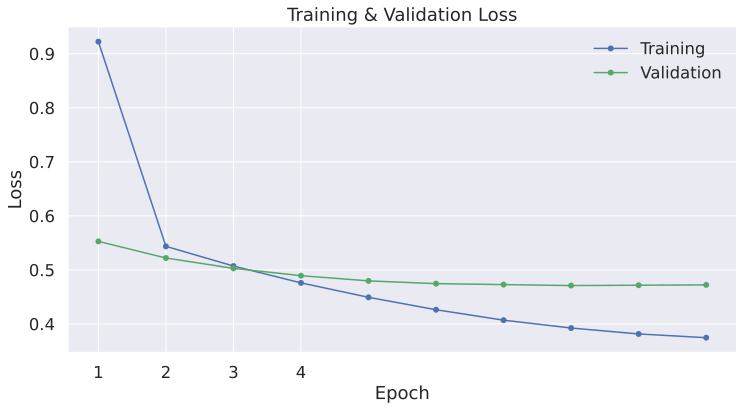

In [29]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### **Generation**

In [30]:
model.eval()
seed_everything(42)

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=25 # if set then no sample?
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Why did the blonde blush?. Because she heard the car was weaving through the intersection.


1: How do you make your pants fit like an airplane?. Fold them over.


2: When I was in school I asked a Japanese girl to take me to the dance floor. She got really frustrated and said, "Do not do it, do not do it, do not do it..." I said,"Do not do it, do not do it..." She got really angry and asked, "Is that why you are in the middle of doing the dance floor?" I said,"No, I am in the middle of fucking Go!"


3: A blonde, a brunette and a redhead are on a boat.. As they leave port, a redhead asks "Is anyone there drunk?" "No, but I sure do want to catch some light."


4: I used to be a pornstar but now I am trying to make ends meet..


5: A man tried to sell me a coffin....... I told him that was not the spirit.


6: A guy goes to the doctor with a swollen penis.... He asks, "Doc, do you need any help with your erection?" The doctor replies, "It is not hard, just a few drops of cream."


7:

### **Save Model**

In [31]:
output_dir = '/content/drive/My Drive/NLP_jokes_generation/models/v4/'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/My Drive/NLP_jokes_generation/models/v4/tokenizer_config.json',
 '/content/drive/My Drive/NLP_jokes_generation/models/v4/special_tokens_map.json',
 '/content/drive/My Drive/NLP_jokes_generation/models/v4/vocab.json',
 '/content/drive/My Drive/NLP_jokes_generation/models/v4/merges.txt',
 '/content/drive/My Drive/NLP_jokes_generation/models/v4/added_tokens.json')